<a href="https://colab.research.google.com/github/gyasifred/NLP-Techniques/blob/main/experimenting_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Dict
from termcolor import colored
import numpy as np
from pprint import pprint
from IPython.core.display import display, HTML

In [2]:
def load_and_preprocess_data(train_path: str, test_path: str) -> Tuple[pd.DataFrame, pd.DataFrame, LabelEncoder]:
    """Load and preprocess the training and testing data.

    Args:
        train_path (str): The file path for the training data CSV.
        test_path (str): The file path for the testing data CSV.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame, LabelEncoder]: A tuple containing the training DataFrame,
        the testing DataFrame, and the fitted LabelEncoder.
    """
    try:
        # Load the data
        train_df = pd.read_csv(train_path)
        test_df = pd.read_csv(test_path)

        # Check if necessary columns exist
        if 'prognosis' not in train_df.columns or 'prognosis' not in test_df.columns:
            raise ValueError("The 'prognosis' column is missing from the datasets.")
        if 'symptoms' not in train_df.columns or 'symptoms' not in test_df.columns:
            raise ValueError("The 'symptoms' column is missing from the datasets.")

        # Initialize and fit the LabelEncoder
        label_encoder = LabelEncoder()
        train_df['prognosis'] = label_encoder.fit_transform(train_df['prognosis'])
        test_df['prognosis'] = label_encoder.transform(test_df['prognosis'])

        return train_df, test_df, label_encoder

    except FileNotFoundError as e:
        print(f"Error: {e}")
        raise
    except pd.errors.EmptyDataError:
        print("Error: The file is empty.")
        raise
    except Exception as e:
        print(f"An error occurred: {e}")
        raise


In [3]:
# Load and preprocess data
train_df, test_df, label_encoder = load_and_preprocess_data("/content/drive/MyDrive/Training.csv",
                                                            "/content/drive/MyDrive/Testing.csv")

In [4]:
num_classes = len(label_encoder.classes_)
print(f"Number of classes: {num_classes}")

Number of classes: 41


In [5]:
tokenizer = BertTokenizer.from_pretrained("/content/drive/MyDrive/MT/trained_biobert_tokenizer")
model = BertForSequenceClassification.from_pretrained("/content/drive/MyDrive/MT/trained_biobert_model",
                                                      attn_implementation='eager',
                                                      num_labels=num_classes, output_attentions=True)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")
model.to(device)

Using device: cuda


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [6]:
class CustomTextDataset(Dataset):
    """Custom Dataset class for text data."""

    def __init__(self, dataframe: pd.DataFrame, tokenizer: BertTokenizer, max_length: int):
        """
        Initializes the dataset with the DataFrame, tokenizer, and max length.

        Args:
            dataframe (pd.DataFrame): DataFrame containing the symptoms and prognosis.
            tokenizer (AutoTokenizer): Tokenizer for the specific transformer model.
            max_length (int): Maximum length of the tokenized input.
        """
        self.tokenizer = tokenizer
        self.texts = dataframe['symptoms'].astype(str).tolist()  # Convert to list for easier indexing
        self.labels = dataframe['prognosis'].values
        self.max_length = max_length

    def __len__(self) -> int:
        """Returns the total number of samples in the dataset."""
        return len(self.texts)

    def __getitem__(self, index: int) -> Dict[str, torch.Tensor]:
        """Generates one sample of data."""
        text = self.texts[index]
        label = self.labels[index]

        # Tokenize the text
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"  # Returns PyTorch tensors
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),  # Remove the extra dimension
            'attention_mask': encoding['attention_mask'].squeeze(0),  # Remove the extra dimension
            'labels': torch.tensor(label, dtype=torch.long)  # Ensure label is a tensor
        }

In [7]:
def create_data_loaders(train_df: pd.DataFrame, test_df: pd.DataFrame, tokenizer: BertTokenizer, batch_size: int = 16) -> Tuple[DataLoader, DataLoader]:
    """Create DataLoaders for training and testing."""
    train_dataset = CustomTextDataset(train_df, tokenizer, max_length=512)
    test_dataset = CustomTextDataset(test_df, tokenizer, max_length=512)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, test_loader

In [8]:
# Create data loaders
train_loader, test_loader = create_data_loaders(train_df,
                                                test_df, tokenizer)

In [9]:
def evaluate_model(model: BertForSequenceClassification, test_loader: DataLoader,
                   label_encoder: LabelEncoder):
    """Evaluate the model."""
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs.logits, dim=1)

            predictions.extend(preds.cpu().tolist())
            true_labels.extend(labels.cpu().tolist())

    accuracy = accuracy_score(true_labels, predictions)
    report = classification_report(true_labels, predictions,
                                   target_names=label_encoder.classes_)

    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(report)

In [10]:
# Evaluate the model
pprint(evaluate_model(model, test_loader, label_encoder))

Accuracy: 1.0000
Classification Report:
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        25
                                   AIDS       1.00      1.00      1.00        24
                                   Acne       1.00      1.00      1.00        24
                    Alcoholic hepatitis       1.00      1.00      1.00        25
                                Allergy       1.00      1.00      1.00        24
                              Arthritis       1.00      1.00      1.00        24
                       Bronchial Asthma       1.00      1.00      1.00        25
                   Cervical spondylosis       1.00      1.00      1.00        24
                            Chicken pox       1.00      1.00      1.00        24
                    Chronic cholestasis       1.00      1.00      1.00        25
                            Common Cold       1.00      1.00      1.

In [11]:
def get_predictions_with_probabilities(text: str, model: BertForSequenceClassification,
                                       tokenizer: BertTokenizer, label_encoder: LabelEncoder):
    """Get predictions with probabilities for a given text."""
    inputs = tokenizer(text, return_tensors="pt", padding=True,
                       truncation=True, max_length=512).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    probs = F.softmax(logits, dim=-1)

    predicted_class = probs.argmax(dim=-1).item()
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]

    probs_np = probs.cpu().numpy()[0]
    labels = label_encoder.inverse_transform(range(len(probs_np)))
    df = pd.DataFrame({'Label': labels, 'Probability': probs_np})
    df = df.sort_values('Probability', ascending=False).reset_index(drop=True)
    return predicted_label, df

In [12]:
# Example usage of prediction and attention visualization
text_example = "58yo man presents with stomach pain and acute shortness of breath"
label, prob = get_predictions_with_probabilities(text_example, model, tokenizer, label_encoder)
print(f"Predicted prognosis: {label}")
print(f"\nProbabilities\n: {prob}")


Predicted prognosis: GERD

Probabilities
:                                       Label  Probability
0                                      GERD     0.215991
1                       Peptic ulcer diseae     0.132879
2                           Gastroenteritis     0.036150
3                            Varicose veins     0.035977
4                                  Migraine     0.033972
5                       Alcoholic hepatitis     0.031673
6                   Urinary tract infection     0.031369
7                      Cervical spondylosis     0.030808
8                           Osteoarthristis     0.029878
9                                 Arthritis     0.027579
10                            Drug Reaction     0.024230
11             Dimorphic hemmorhoids(piles)     0.023900
12                                Diabetes      0.022236
13                                Psoriasis     0.021148
14                                  Malaria     0.020902
15                            Hypertension   

In [13]:
def plot_attention(text: str, model: BertForSequenceClassification,
                   tokenizer: BertTokenizer, label_encoder: LabelEncoder,
                   layer_num: int = -1, head_num: int = -1):
    """
    Plot attention heatmap for a given text using BERT, excluding [CLS] and [SEP] tokens.
    Args:
    text (str): Input text to analyze.
    model (BertForSequenceClassification): Pre-trained BERT model.
    tokenizer (BertTokenizer): BERT tokenizer.
    label_encoder (LabelEncoder): Encoder for transforming numeric predictions to class labels.
    layer_num (int): Layer number to extract attention from (default: last layer).
    head_num (int): Attention head number to use (default: last head).
    """
    # Tokenize input and move to the same device as the model
    device = next(model.parameters()).device
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True,
                       max_length=512).to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    # Extract attention weights for specified layer and head
    attentions = outputs.attentions[layer_num][0].cpu().numpy()

    # Get the tokenized words (excluding [CLS] and [SEP])
    words = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])[1:-1]

    # Remove attention for [CLS] and [SEP] tokens
    attention_matrix = attentions[head_num][1:-1, 1:-1]

    # Calculate prediction
    logits = outputs.logits
    probs = F.softmax(logits, dim=-1)
    predicted_class = probs.argmax(dim=-1).item()
    prediction = label_encoder.inverse_transform([predicted_class])[0]

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention_matrix, xticklabels=words, yticklabels=words, cmap='viridis')
    plt.title(f"Attention Heatmap (Layer: {layer_num}, Head: {head_num})\nPrediction: {prediction}")
    plt.tight_layout()
    plt.show()

    # Print the input text for reference
    print(f"Input text: {text}")
    print(f"Tokenized words: {' '.join(words)}")

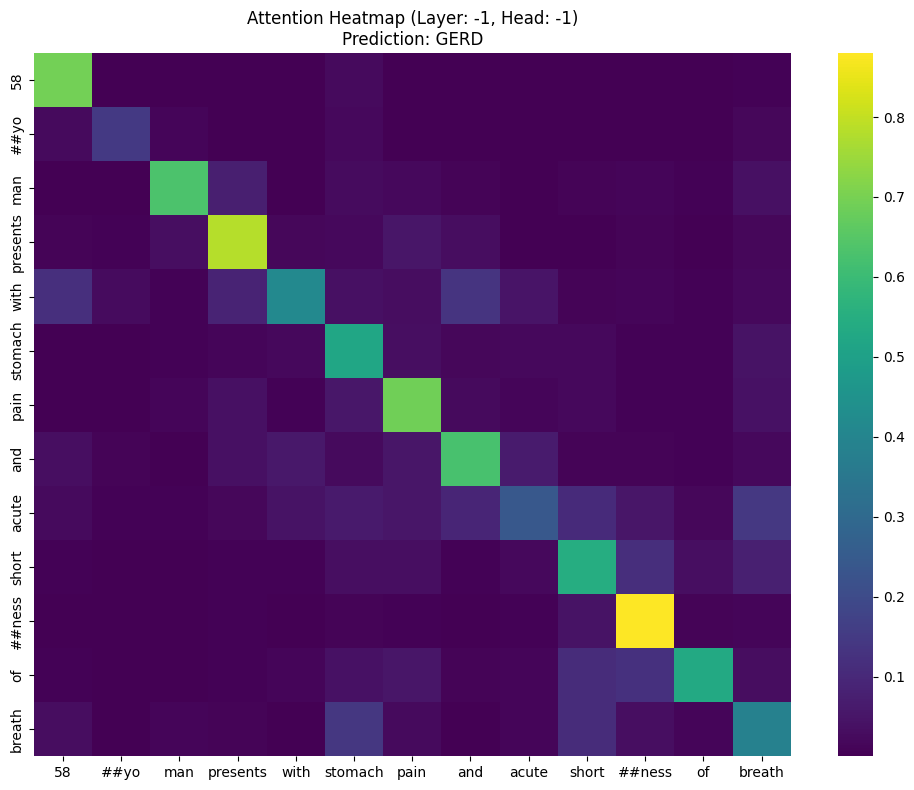

Input text: 58yo man presents with stomach pain and acute shortness of breath
Tokenized words: 58 ##yo man presents with stomach pain and acute short ##ness of breath


In [14]:
plot_attention(text_example, model, tokenizer,label_encoder, layer_num= -1, head_num= -1)

In [15]:
def plot_attention_barh(text: str, model: BertForSequenceClassification,
                        tokenizer: BertTokenizer, label_encoder: LabelEncoder,
                        layer_num: int = -1, head_num: int = -1):
    """
    Plot attention heatmap and horizontal bar graph for a given text using BERT, excluding [CLS] and [SEP] tokens.
    Args:
    text (str): Input text to analyze.
    model (BertForSequenceClassification): Pre-trained BERT model.
    tokenizer (BertTokenizer): BERT tokenizer.
    label_encoder (LabelEncoder): Encoder for transforming numeric predictions to class labels.
    layer_num (int): Layer number to extract attention from (default: last layer).
    head_num (int): Attention head number to use (default: last head).
    """
    # Tokenize input and move to the same device as the model
    device = next(model.parameters()).device
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True,
                       max_length=512).to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    # Extract attention weights for specified layer and head
    attentions = outputs.attentions[layer_num][0].cpu().numpy()

    # Get the tokenized words (excluding [CLS] and [SEP])
    words = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])[1:-1]

    # Remove attention for [CLS] and [SEP] tokens
    attention_matrix = attentions[head_num][1:-1, 1:-1]

    # Calculate prediction
    logits = outputs.logits
    probs = F.softmax(logits, dim=-1)
    predicted_class = probs.argmax(dim=-1).item()
    prediction = label_encoder.inverse_transform([predicted_class])[0]

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    fig.suptitle(f"Attention Analysis (Layer: {layer_num}, Head: {head_num})\nPrediction: {prediction}", fontsize=16)

    # Plot heatmap
    sns.heatmap(attention_matrix, xticklabels=words, yticklabels=words, cmap='viridis', ax=ax1)
    ax1.set_title("Attention Heatmap")

    # Calculate average attention for each word
    avg_attention = attention_matrix.mean(axis=0)

    # Plot horizontal bar graph
    y_pos = np.arange(len(words))
    ax2.barh(y_pos, avg_attention, align='center')
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(words)
    ax2.invert_yaxis()  # labels read top-to-bottom
    ax2.set_xlabel('Average Attention')
    ax2.set_title('Average Attention per Token')

    plt.tight_layout()
    plt.show()

    # Print the input text for reference
    print(f"Input text: {text}")
    print(f"Tokenized words: {' '.join(words)}")

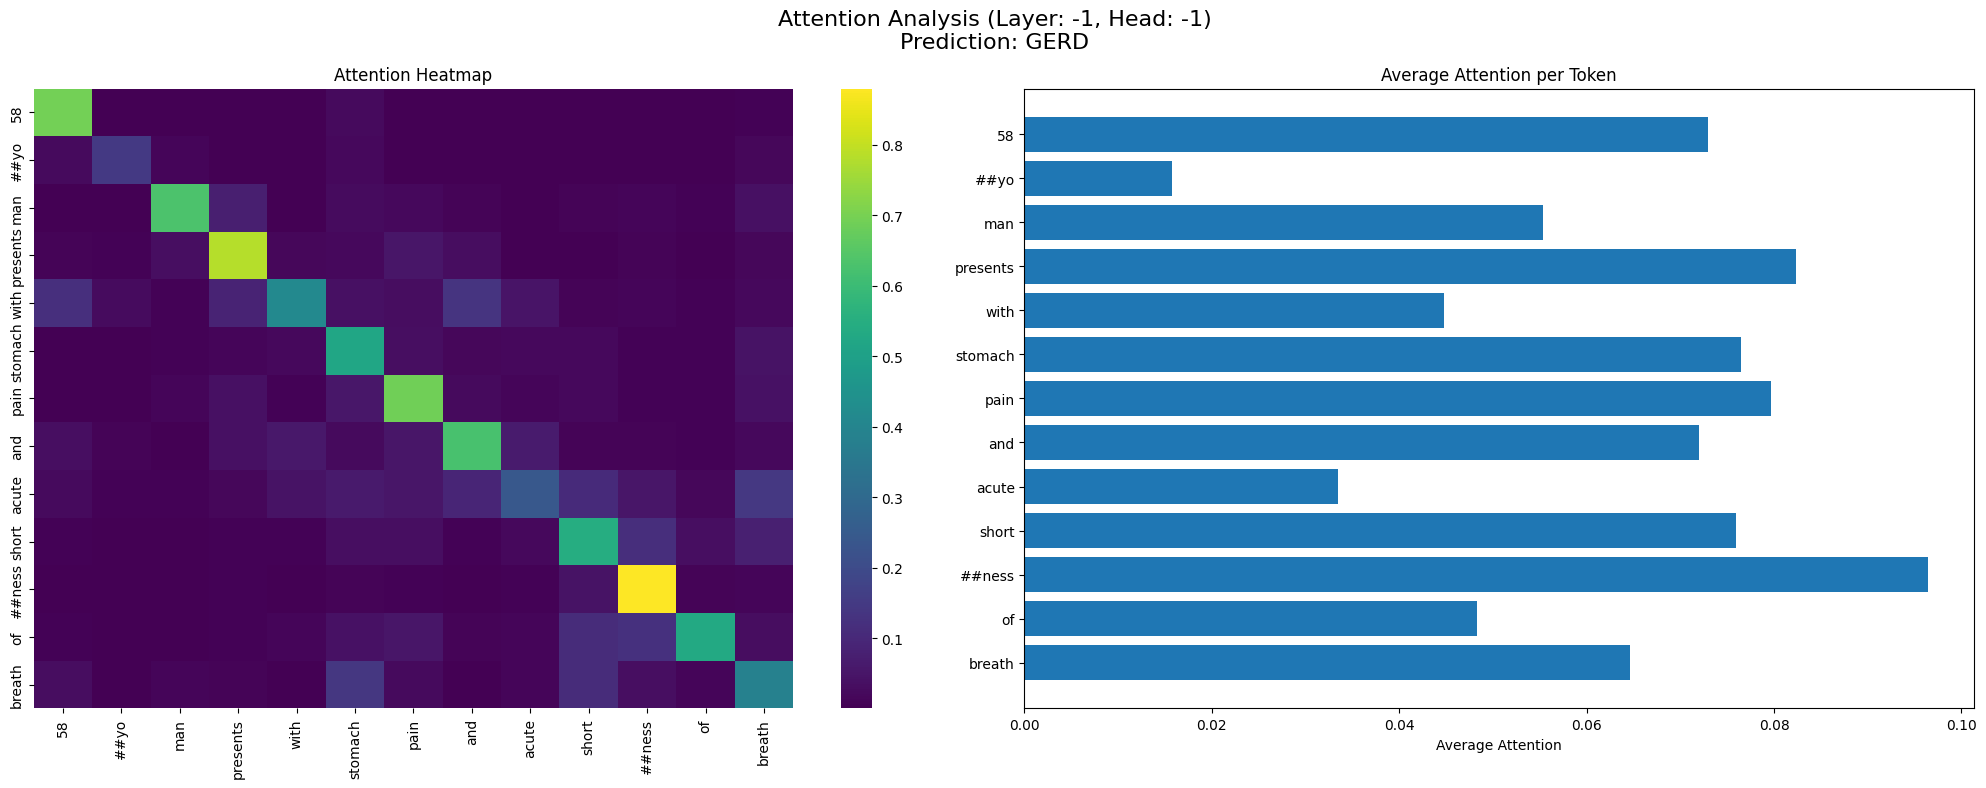

Input text: 58yo man presents with stomach pain and acute shortness of breath
Tokenized words: 58 ##yo man presents with stomach pain and acute short ##ness of breath


In [16]:
plot_attention_barh(text_example, model, tokenizer,label_encoder, layer_num= -1, head_num= -1)

In [17]:
def get_attention_and_predict(text: str, model: BertForSequenceClassification,
                              tokenizer: BertTokenizer,label_encoder: LabelEncoder,
                              layer_num: int = -1,
                              head_num: int = -1):
    """
    Get attention scores and predict for a given text using BERT.
    Args:
    text (str): Input text to analyze.
    model (BertForSequenceClassification): Pre-trained BERT model.
    tokenizer (BertTokenizer): BERT tokenizer.
    layer_num (int): Layer number to extract attention from (default: last layer).
    head_num (int): Attention head number to use (default: first head).
    label_encoder (LabelEncoder): Encoder for transforming numeric predictions to class labels.
    Returns:
    tuple: (prediction, word with max attention, dict of word attentions)
    """
    # Tokenize input and move to the same device as the model
    device = next(model.parameters()).device
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True,
                       max_length=512).to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
    # Extract attention weights for specified layer and head
    attentions = outputs.attentions[layer_num][0, head_num].cpu().numpy()

    # Get attention weights, ignoring [CLS] and [SEP] tokens
    cls_attention = attentions[0, 1:-1]  # Use first row (CLS token) and ignore first and last column

    # Get the tokenized words
    words = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])[1:-1]  # Ignore [CLS] and [SEP]
    # Calculate prediction probability
    logits = outputs.logits
    probs = F.softmax(logits, dim=-1)
    predicted_class = probs.argmax(dim=-1).item()
    prediction = label_encoder.inverse_transform([predicted_class])[0]
    word_attentions = {}
    for word, attn in zip(words, cls_attention):
        if word.startswith('##'):
            word_attentions[list(word_attentions.keys())[-1]] += attn
        else:
            word_attentions[word] = attn
    # Find word with highest attention
    max_attention_word = max(word_attentions, key=word_attentions.get)

    return prediction, max_attention_word, word_attentions

In [18]:
# Example usage of prediction and attention visualization"
prediction, max_attention_word, word_attentions = get_attention_and_predict(text_example,
                                                                            model, tokenizer, label_encoder)
print(f"Predicted prognosis: {prediction}")
print(f"\nMaximum Attention Word: {max_attention_word}")
print(f"\nWord Attention Scores: {word_attentions}")


Predicted prognosis: GERD

Maximum Attention Word: 58

Word Attention Scores: {'58': 0.2798581, 'man': 0.015350814, 'presents': 0.019697499, 'with': 0.0068563526, 'stomach': 0.14284287, 'pain': 0.04100351, 'and': 0.014299631, 'acute': 0.021526407, 'short': 0.0461142, 'of': 0.017557858, 'breath': 0.13025656}


In [19]:
# from termcolor import colored

# def shade_highest_attention_word(text, max_attention_word):
#     words = text.split()

#     # Predefined background color for max attention (yellow in this case)
#     shaded_words = [colored(word, 'black', 'on_yellow') if word == max_attention_word else word for word in words]

#     return ' '.join(shaded_words)

# # Example usage
# text = "The quick brown fox jumps over the lazy dog"
# max_attention_word = "fox"
# print(shade_highest_attention_word(text, max_attention_word))

In [20]:
from IPython.core.display import display, HTML

def shade_highest_attention_word_html(text, max_attention_word):
    words = text.split()

    # Define a custom color using a hex code or RGB
    attention_color = '#800080'  # Example yellow color for max attention word

    # Wrap words in <span> tags with custom background color for max attention word
    shaded_words = [f'<span style="background-color:{attention_color}; padding:2px;">{word}</span>'
                    if max_attention_word in word else word for word in words]

    # Return the result as a single string
    return ' '.join(shaded_words)

# Display the result in Jupyter or Colab
display(HTML(shade_highest_attention_word_html(text_example, max_attention_word)))


In [21]:
# Example Hex Codes for Different Colors:

# Reds
# '#FF0000' - Bright Red
# '#FF6347' - Tomato
# '#FF4500' - Orange Red
# '#DC143C' - Crimson

# Greens
# '#00FF00' - Bright Green
# '#32CD32' - Lime Green
# '#228B22' - Forest Green
# '#006400' - Dark Green

# Blues
# '#0000FF' - Bright Blue
# '#1E90FF' - Dodger Blue
# '#4169E1' - Royal Blue
# '#00008B' - Dark Blue

# Yellows
# '#FFFF00' - Bright Yellow
# '#FFD700' - Gold
# '#FFCC00' - Yellow Orange
# '#FFA500' - Orange

# Purples
# '#800080' - Purple
# '#8A2BE2' - Blue Violet
# '#9370DB' - Medium Purple
# '#4B0082' - Indigo

# Oranges
# '#FFA07A' - Light Salmon
# '#FF8C00' - Dark Orange
# '#FF4500' - Orange Red
# '#FF6347' - Tomato

# Grays
# '#808080' - Gray
# '#A9A9A9' - Dark Gray
# '#C0C0C0' - Silver
# '#D3D3D3' - Light Gray

# You can replace the color in the HTML code with any of these hex codes.
